# LA Metro Routes 720 and 10

Pick a route that is pretty long, and compare how the stops are aggregated to AM/PM peak.

Compare and map to figure out how to match the segmenting of HQTA segments

In [1]:
import dask.dataframe as dd
import dask_geopandas
import datetime as dt
import geopandas as gpd
import pandas as pd
import zlib

from siuba import *

import utilities
import B1_bus_corridors as bus_corridors
from A1_rail_ferry_brt import analysis_date
from shared_utils import rt_utils, geography_utils

GCS_FILE_PATH = utilities.GCS_FILE_PATH

itp_id = 182
date_str = analysis_date.strftime(rt_utils.FULL_DATE_FMT)

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Eric's original method by `shape_id`

Select just the `shape_id` if it starts with 720 or 10-, and compile those results.

Make minimal modifications, just add subsetting within the trips table to grab 2 routes.

In [2]:
def single_shape_hqta(
    routelines, trips, stop_times, stops, route_count_by_stop, shape_id, hqta
):
    """Starting with a single GTFS shape, split that shape into segments and determine if each segment qualifies
    as an HQTA. Existing segments within a shape are dropped for that shape, since their peak frequency and
    HQTA status would have already been calculated for a previous shape.
    """

    single_line = routelines >> filter(_.shape_id == shape_id)
    if single_line.size == 0 or single_line.geometry.isna().all():
        print(f"no geometry for shape {shape_id}")
        return
    
    debug_ids = []
    if shape_id in debug_ids:
        print(f"***debug shape*** {shape_id}")
        debug_dict[f"{shape_id}_single_line"] = single_line
        debug_dict[f"{shape_id}_hqta"] = hqta

    calculated_stops = []
    ## TODO any way to make more efficient? a pre-calculated shape overlap? something else?
    if hqta.size != 0:
        already_calculated = hqta.dissolve(
            by="calitp_itp_id"
        )  ## get single polygon of HQTA calculation complete area
        single_line = single_line.overlay(
            already_calculated, how="difference"
        )  ## drop calculation complete area from current shape
        if single_line.size == 0:
            segments_with_max_stop = None
            print(f"already calculated corridor for shape {shape_id}")
            return

    segmented = gpd.GeoDataFrame() ##changed to gdf?
    for segment in utilities.create_segments(single_line.geometry):
        to_append = single_line.drop(columns=["geometry"])
        to_append["geometry"] = segment
        segmented = pd.concat((segmented, to_append))

    segmented = segmented.reset_index()
    if shape_id in debug_ids:
        debug_dict[f"{shape_id}_a_segmented"] = segmented

    try:
        segmented["segment_sequence"] = segmented.index.astype(str)
        assert 'calitp_itp_id' in segmented.columns
        # segmented = segmented.astype({"calitp_itp_id": str}) ## casting this to string is bad for exports...
        ## instead, cast when generating segment id below...
    except:
        print(f"segmented shape has no itp_id {shape_id}")
        return

    ## compute (hopefully unique) hash of segment id that can be used across routes/operators
    segmented["hqta_segment_id"] = segmented.apply(
        lambda x: zlib.crc32(
            (str(x.calitp_itp_id) + x.shape_id + x.segment_sequence).encode("utf-8")
        ),
        axis=1,
    )

    segmented.geometry = segmented.buffer(
        50
    )  ##generous buffer for street/sidewalk width? Required to spatially find stops within each segment

    if shape_id in debug_ids:
        debug_dict[f"{shape_id}_segmented"] = segmented
        debug_dict[f"{shape_id}_stops"] = stops
        debug_dict[f"{shape_id}_route_ct_by_stop"] = route_count_by_stop

    segments_with_max_stop = segmented.apply(
        utilities.find_stop_with_high_trip_count,
        axis=1,
        args=(stops, stop_times, 1, calculated_stops),
    )

    if not "stop_id" in segments_with_max_stop.columns:
        segments_with_top2_stops = None
        print(f"no stops for shape {shape_id}")
        return  ## no stops within segment

    max_stop_times = (
        stop_times
        >> select(_.stop_id, _.trip_id, _.departure_time)
        >> inner_join(_, segments_with_max_stop, on="stop_id")
    )  ## filter stop_times to the key stops in each segment
    max_stop_times = max_stop_times.dropna(subset=["departure_time"])
    max_stop_times = max_stop_times.drop_duplicates(
        subset=["trip_id", "hqta_segment_id"]
    )  ## filter duplicates for top2 approach

    if shape_id in debug_ids:
        debug_dict[f"{shape_id}_max_stop0"] = max_stop_times

    max_stop_times["departure_time"] = max_stop_times["departure_time"].apply(
        utilities.fix_arrival_time
    )  ## reformat GTFS time to a format datetime can ingest
    max_stop_times["departure_dt"] = max_stop_times["departure_time"].apply(
        lambda x: dt.datetime.strptime(x, "%H:%M:%S")
    )
    max_stop_times["departure_hour"] = max_stop_times["departure_dt"].apply(
        lambda x: x.hour
    )

    if max_stop_times.size == 0:
        print(f"no commute hour trips for shape {shape_id}")
        return

    if shape_id in debug_ids:
        debug_dict[f"{shape_id}_max_stop"] = max_stop_times

    ## new flexible peak
    segment_am_max = (
        max_stop_times
        >> count(_.hqta_segment_id, _.departure_hour)
        >> filter(_.departure_hour < 12)
        >> group_by(_.hqta_segment_id)
        >> summarize(am_max_trips=_.n.max())
    )

    segment_pm_max = (
        max_stop_times
        >> count(_.hqta_segment_id, _.departure_hour)
        >> filter(_.departure_hour >= 12)
        >> group_by(_.hqta_segment_id)
        >> summarize(pm_max_trips=_.n.max())
    )
    try:
        segment_peak_service = segment_am_max >> inner_join(
            _, segment_pm_max, on="hqta_segment_id"
        )
        segment_peak_service["hq_transit_corr"] = segment_peak_service.apply(
            lambda x: x.am_max_trips > 4 and x.pm_max_trips > 4, axis=1
        )
    except:  ## append when all segments only have am or pm trips, not an hqta by definition
        segment_peak_service = pd.concat((segment_am_max, segment_pm_max))
        segment_peak_service["hq_transit_corr"] = False

    segment_peak_service = segment_peak_service.reset_index(drop=True)

    single_hqta = segments_with_max_stop >> inner_join(
        _, segment_peak_service, on="hqta_segment_id"
    )
    single_hqta = single_hqta >> select(-_.calitp_extracted_at, -_.index, -_.n_trips)

    if shape_id in debug_ids:
        debug_dict[f"{shape_id}_single_hqta"] = single_hqta

    return single_hqta.reset_index(drop=True)

In [3]:
FILE_PATH = f"{rt_utils.GCS_FILE_PATH}cached_views/"

def single_operator_hqta(itp_id, analysis_date):

    global debug_dict
    debug_dict = {}
    
    '''
    # shapes, trips, stop_times, stops = views
    routelines = rt_utils.get_routelines(itp_id, analysis_date)
    ## force clear to ensure route type data present
    trips = rt_utils.get_trips(itp_id, analysis_date, force_clear=True, route_types = ['3'])
    stop_times = rt_utils.get_stop_times(itp_id, analysis_date)
    stops = rt_utils.get_stops(itp_id, analysis_date)
    '''
    date_str = analysis_date.strftime(rt_utils.FULL_DATE_FMT)

    routelines = gpd.read_parquet(f"{FILE_PATH}routelines_{itp_id}_{date_str}.parquet")
    trips = pd.read_parquet(f"{FILE_PATH}trips_{itp_id}_{date_str}.parquet")
    stop_times = pd.read_parquet(f"{FILE_PATH}st_{itp_id}_{date_str}.parquet")
    stops = gpd.read_parquet(f"{FILE_PATH}stops_{itp_id}_{date_str}.parquet")
    
    distinct_routes = (
        trips
        >> distinct(_.route_id, _.shape_id, _.direction_id, _keep_all=True)
        >> select(_.calitp_itp_id, _.route_id, _.shape_id, _.direction_id, _.trip_id)
    )
    
    distinct_routes = distinct_routes[
        (distinct_routes.route_id.str.startswith("720")) | 
        (distinct_routes.route_id.str.startswith("10-"))
    ].reset_index(drop=True)

    route_count_by_stop = (
        stop_times
        >> select(_.stop_id, _.trip_id)
        >> inner_join(_, distinct_routes, on="trip_id")
        >> count(_.stop_id)
        >> rename(n_routes=_.n)
        >> arrange(-_.n_routes)
    )

    hqta = gpd.GeoDataFrame()
    ## start with shapes including the highest number of trips
    trips_shape_sorted = (distinct_routes.groupby("shape_id")
        .count()
        .sort_values(by="trip_id", ascending=False)
        .index
    )
    trips_shape_sorted = pd.Series(trips_shape_sorted)
    total_shapes = len(trips_shape_sorted)
    print(f"there are {total_shapes} shapes total")
    for ix, shape_id in trips_shape_sorted.items():
        print(f"calculating for shape_id {shape_id}")
        if ix % 25 == 0:
            print(
                f"progress: {ix}/{total_shapes} shapes ({round(((ix/total_shapes)*100), 2)}%)"
            )
        # try:
        result = single_shape_hqta(
            routelines, trips, stop_times, stops, route_count_by_stop, shape_id, hqta
        )
        hqta = pd.concat((hqta, result))
        # except:
            # print(f"unable to calculate HQTA for shape_id {shape_id}")
        try:
            hqta = hqta.set_crs(geography_utils.CA_NAD83Albers)
        except:
            continue
    return hqta
    # return hqta.drop(columns=['n', 'departure_hour']).reset_index(drop=True)

In [4]:
start = dt.datetime.now()
operator = single_operator_hqta(itp_id, analysis_date)

operator[operator.shape_id.str.startswith("720")].to_parquet("./data/eric_720.parquet")
operator[operator.shape_id.str.startswith("10")].to_parquet("./data/eric_10.parquet")

end = dt.datetime.now()
print(f"execution time: {end-start}")

there are 26 shapes total
calculating for shape_id 100751_FEB22
progress: 0/26 shapes (0.0%)
calculating for shape_id 100755_FEB22
calculating for shape_id 7201278_FEB22
calculating for shape_id 7201277_FEB22
calculating for shape_id 7201276_FEB22
calculating for shape_id 7201275_FEB22
calculating for shape_id 7201274_FEB22
already calculated corridor for shape 7201274_FEB22
calculating for shape_id 7201273_FEB22
already calculated corridor for shape 7201273_FEB22
calculating for shape_id 7201272_FEB22
already calculated corridor for shape 7201272_FEB22
calculating for shape_id 7201271_FEB22
calculating for shape_id 100780_FEB22
calculating for shape_id 100779_FEB22
calculating for shape_id 100778_FEB22
already calculated corridor for shape 100778_FEB22
calculating for shape_id 100777_FEB22
already calculated corridor for shape 100777_FEB22
calculating for shape_id 100776_FEB22
already calculated corridor for shape 100776_FEB22
calculating for shape_id 100775_FEB22
calculating for shap

/tmp/ipykernel_1660/471678708.py:4: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
/tmp/ipykernel_1660/471678708.py:5: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet

In [5]:
'''
# This is the equivalent calculation 
# Make sure I'm doing this, otherwise, counts won't match
(max_stop_times.groupby(["hqta_segment_id", "departure_hour"])
 .agg({"trip_id": "count"})
 .reset_index()
 .groupby(["hqta_segment_id"])
 .agg({"trip_id": "max"})
 .reset_index()
)
'''

'\n# This is the equivalent calculation \n# Make sure I\'m doing this, otherwise, counts won\'t match\n(max_stop_times.groupby(["hqta_segment_id", "departure_hour"])\n .agg({"trip_id": "count"})\n .reset_index()\n .groupby(["hqta_segment_id"])\n .agg({"trip_id": "max"})\n .reset_index()\n)\n'

## Tiff's method, use dask 

In [6]:
# Import data
FILE_PATH = f"{rt_utils.GCS_FILE_PATH}cached_views/"

routelines = dask_geopandas.read_parquet(
    f"{FILE_PATH}routelines_{itp_id}_{date_str}.parquet")
trips = dd.read_parquet(f"{FILE_PATH}trips_{itp_id}_{date_str}.parquet")
stop_times = dd.read_parquet(f"{FILE_PATH}st_{itp_id}_{date_str}.parquet")
stops = dask_geopandas.read_parquet(f"{FILE_PATH}stops_{itp_id}_{date_str}.parquet")

In [7]:
start = dt.datetime.now()

operator2 = bus_corridors.single_operator_hqta(routelines, trips, stop_times, stops)

operator2[operator2.shape_id.str.startswith("720")].to_parquet("./data/tiff_720.parquet")
operator2[operator2.shape_id=="100777_FEB22"].to_parquet("./data/tiff_10.parquet")

end = dt.datetime.now()
print(f"execution time: {end-start}")

execution time: 0:00:34.305028


/tmp/ipykernel_1660/784072404.py:5: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
/tmp/ipykernel_1660/784072404.py:6: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet

In [8]:
operator2[operator2.shape_id.str.startswith("10")].shape_id.value_counts()

1080403_FEB22    34
100777_FEB22     27
1060047_FEB22    25
1020068_FEB22    24
1050260_FEB22    21
Name: shape_id, dtype: int64

## Compare

In [9]:
def unique_values(df):
    for c in ["shape_id", "stop_id", "hqta_segment_id", "calitp_itp_id"]:
        print(f"# unique {c}: {df[c].nunique()}")
        
def hqta_distribution(df):
    print(df.hq_transit_corr.value_counts())

def area_trips_stats(df):
    area = df.geometry.area.sum().round(3)
    am_trips = df.am_max_trips.sum().astype(int)
    pm_trips = df.pm_max_trips.sum().astype(int)

    print(f"Area: {area:,}")
    print(f"AM trips sum: {am_trips:,}")
    print(f"PM trips sum: {pm_trips:,}")
    
    
def make_map(gdf):
    one = gdf.plot(column="shape_id", cmap="viridis", 
                   figsize=(20, 20)).set_title("shape_id")
    
    two = gdf.plot(column="hq_transit_corr", cmap="viridis", 
                   figsize=(20, 20)).set_title("HQ transit corr")
    
    print(one)
    print(two)

In [10]:
def compare(eric, tiff):
    print("*************Unique Values*************")
    print("***Eric***")
    unique_values(eric)
    
    print("***Tiff***")
    unique_values(tiff)

    print("\n*************HQTA Distribution*************")
    print("***Eric***")
    hqta_distribution(eric)
    
    print("***Tiff***")
    hqta_distribution(tiff)
    
    print("\n*************HQTA Stats*************")
    print("***Eric***")
    area_trips_stats(eric[eric.hq_transit_corr==True])
    
    print("***Tiff***")
    area_trips_stats(tiff[tiff.hq_transit_corr==True])
    
    print("\n*************Not HQTA Stats*************")
    print("***Eric***")
    area_trips_stats(eric[eric.hq_transit_corr==False])
    
    print("***Tiff***")
    area_trips_stats(tiff[tiff.hq_transit_corr==False])

    print("\n*************Map*************")
    print("***Eric***")
    make_map(eric)
    
    print("***Tiff***")
    make_map(tiff)
        

## 720 comparison

*************Unique Values*************
***Eric***
# unique shape_id: 5
# unique stop_id: 32
# unique hqta_segment_id: 34
# unique calitp_itp_id: 1
***Tiff***
# unique shape_id: 1
# unique stop_id: 23
# unique hqta_segment_id: 25
# unique calitp_itp_id: 1

*************HQTA Distribution*************
***Eric***
True     33
False     1
Name: hq_transit_corr, dtype: int64
***Tiff***
True     24
False     1
Name: hq_transit_corr, dtype: int64

*************HQTA Stats*************
***Eric***
Area: 3,523,838.539
AM trips sum: 629
PM trips sum: 583
***Tiff***
Area: 3,086,639.406
AM trips sum: 425
PM trips sum: 401

*************Not HQTA Stats*************
***Eric***
Area: 132,841.132
AM trips sum: 4
PM trips sum: 5
***Tiff***
Area: 132,841.34
AM trips sum: 4
PM trips sum: 5

*************Map*************
***Eric***
Text(0.5, 1.0, 'shape_id')
Text(0.5, 1.0, 'HQ transit corr')
***Tiff***
Text(0.5, 1.0, 'shape_id')
Text(0.5, 1.0, 'HQ transit corr')


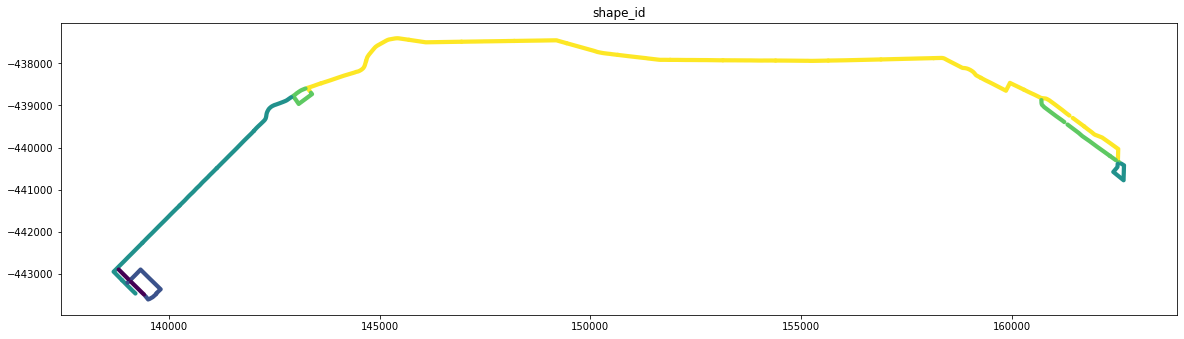

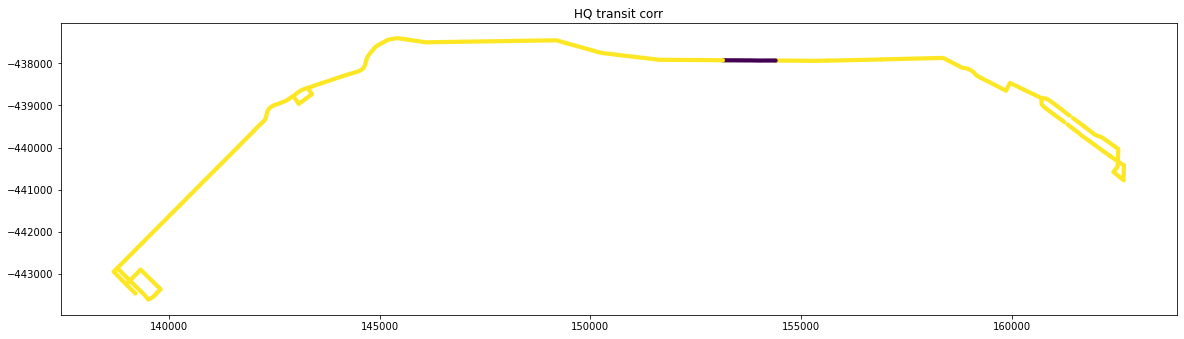

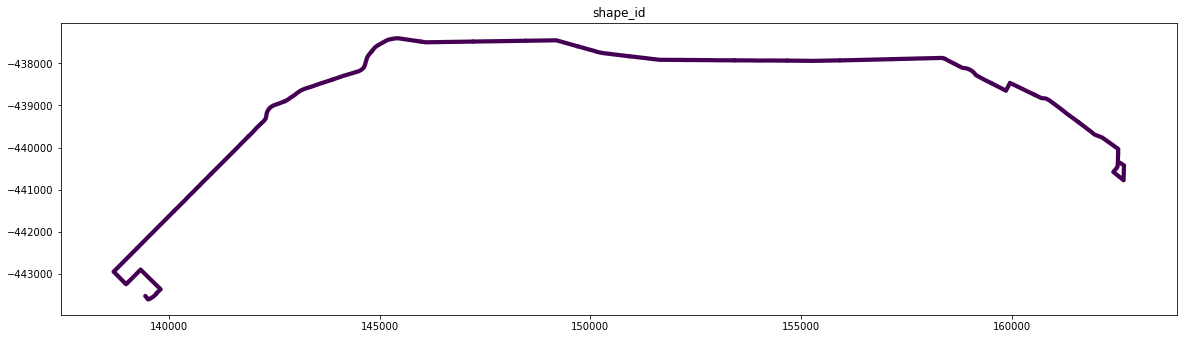

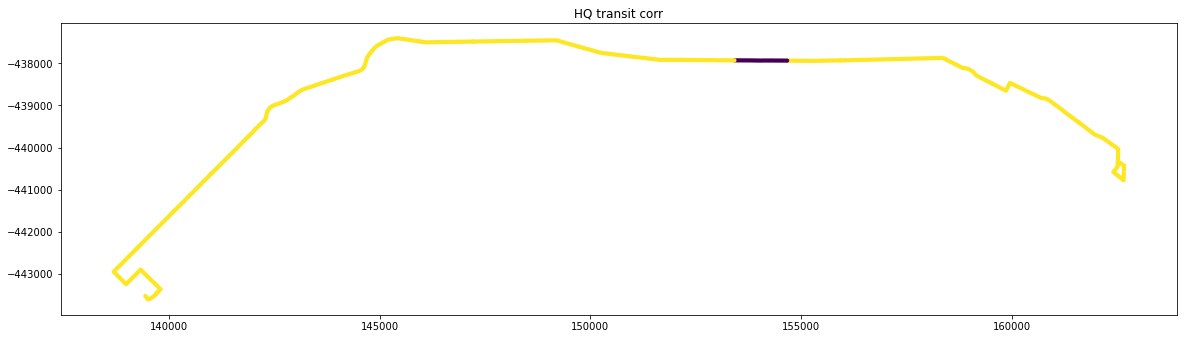

In [11]:
eric = gpd.read_parquet("./data/eric_720.parquet")
tiff = gpd.read_parquet("./data/tiff_720.parquet")

compare(eric, tiff)

## 10 comparison

*************Unique Values*************
***Eric***
# unique shape_id: 6
# unique stop_id: 33
# unique hqta_segment_id: 34
# unique calitp_itp_id: 1
***Tiff***
# unique shape_id: 1
# unique stop_id: 25
# unique hqta_segment_id: 27
# unique calitp_itp_id: 1

*************HQTA Distribution*************
***Eric***
True     23
False    11
Name: hq_transit_corr, dtype: int64
***Tiff***
True     16
False    11
Name: hq_transit_corr, dtype: int64

*************HQTA Stats*************
***Eric***
Area: 2,410,556.024
AM trips sum: 375
PM trips sum: 371
***Tiff***
Area: 2,006,101.694
AM trips sum: 244
PM trips sum: 244

*************Not HQTA Stats*************
***Eric***
Area: 1,279,480.179
AM trips sum: 42
PM trips sum: 40
***Tiff***
Area: 1,457,821.108
AM trips sum: 40
PM trips sum: 41

*************Map*************
***Eric***
Text(0.5, 1.0, 'shape_id')
Text(0.5, 1.0, 'HQ transit corr')
***Tiff***
Text(0.5, 1.0, 'shape_id')
Text(0.5, 1.0, 'HQ transit corr')


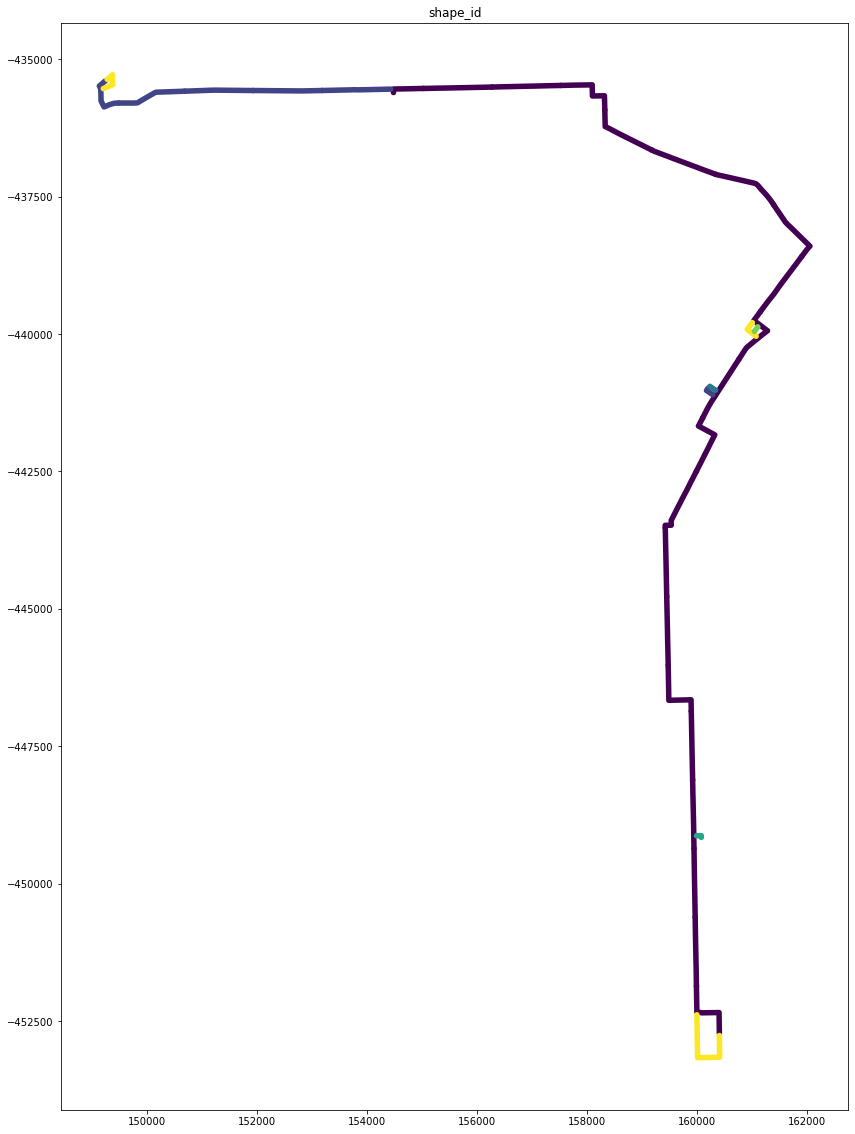

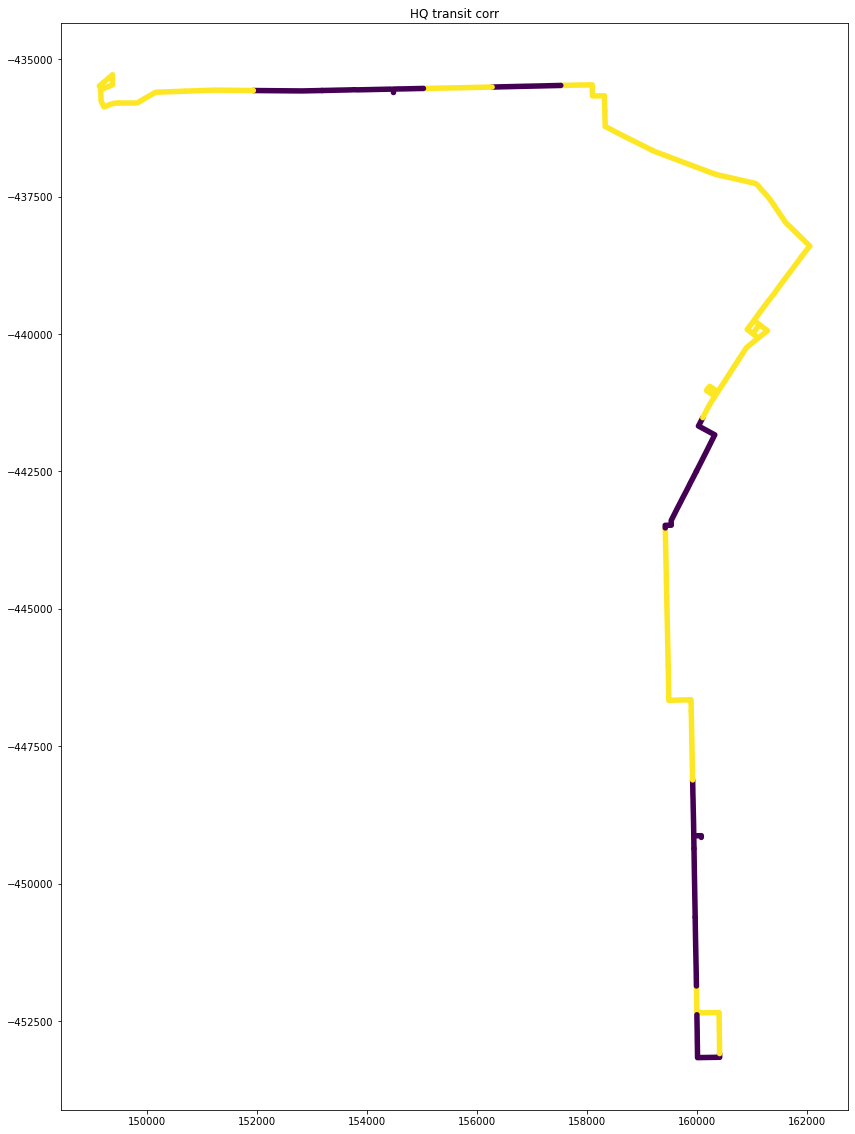

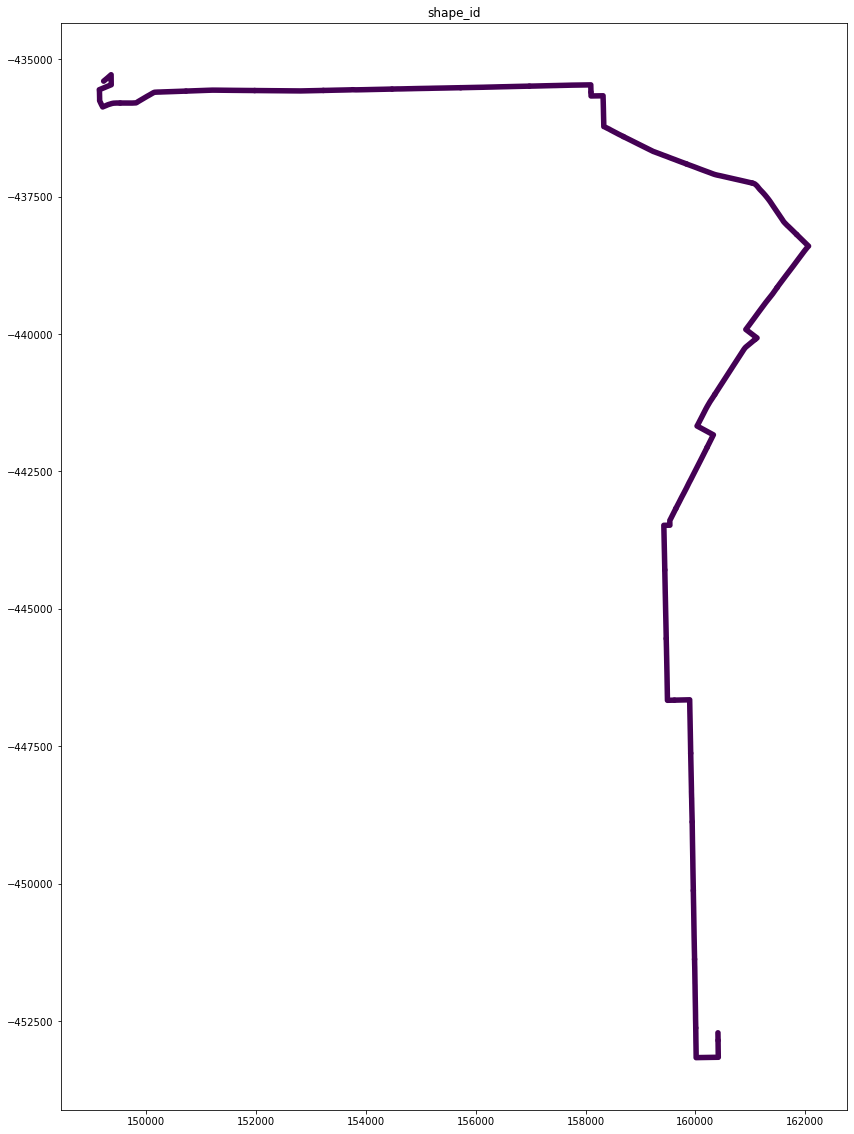

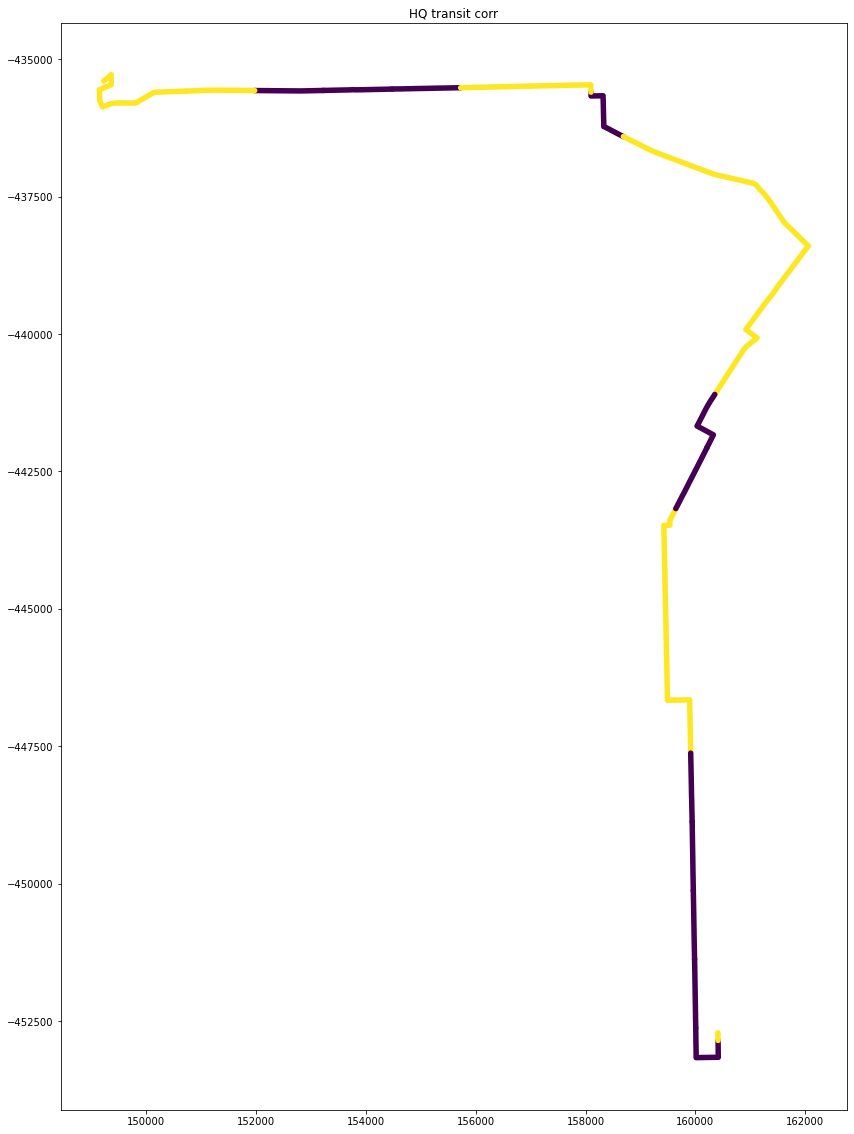

In [12]:
eric = gpd.read_parquet("./data/eric_10.parquet")
tiff = gpd.read_parquet("./data/tiff_10.parquet")

compare(eric, tiff)